# Import packages

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
from sklearn.preprocessing import OneHotEncoder

import torch
import torchaudio
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
from google.colab import drive

from google.colab import drive
import os
# Mount Google Drive
drive.mount('/content/drive')

# Ensure CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


# Loading Dataset Creama-D

In [ ]:
Crema_path = '/content/drive/My Drive/deep_learn_project/AudioWAV/' #/deep_learn_project/
Crema_dir_list = os.listdir(Crema_path)

In [ ]:

emotions_crema = []
paths_crema = []

for it in Crema_dir_list:
    # Storing file paths
    paths_crema.append(Crema_path + it)
    # Storing file emotions
    part = it.split('_')
    if part[2] == 'SAD':
        emotions_crema.append('sad')
    elif part[2] == 'ANG':
        emotions_crema.append('angry')
    elif part[2] == 'DIS':
        emotions_crema.append('disgust')
    elif part[2] == 'FEA':
        emotions_crema.append('fear')
    elif part[2] == 'HAP':
        emotions_crema.append('happy')
    elif part[2] == 'NEU':
        emotions_crema.append('neutral')
    else:
        emotions_crema.append('Unknown')

# Dataframes for emotion of files and paths
emotions_crema_df = pd.DataFrame(emotions_crema, columns=['Emotions'])
path_crema_df = pd.DataFrame(paths_crema, columns=['Path'])
Crema_df = pd.concat([emotions_crema_df, path_crema_df], axis=1)

# Map emotion labels to integer indices
emotion_labels = Crema_df['Emotions'].unique()
emotion_to_idx = {emotion: idx for idx, emotion in enumerate(emotion_labels)}


In [ ]:
!pip install tqdm


#Preprocessing & Augmentation

In [ ]:
from tqdm import tqdm
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification, TrainingArguments, Trainer
import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pickle
import librosa  # Import librosa
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")

# Augmentation functions
def add_noise(waveform, noise_level=0.005):
    noise = torch.randn_like(waveform) * noise_level
    return waveform + noise

def pitch_shift(waveform, sample_rate, n_steps=2):
    waveform_np = waveform.squeeze().numpy()
    y_shifted = librosa.effects.pitch_shift(waveform_np, sr=sample_rate, n_steps=n_steps)
    return torch.tensor(y_shifted).unsqueeze(0)

def preprocess_audio(audio_path, augmentation=None):
    waveform, sample_rate = torchaudio.load(audio_path)
    if sample_rate != feature_extractor.sampling_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=feature_extractor.sampling_rate)
        waveform = resampler(waveform)
        sample_rate = feature_extractor.sampling_rate  # Update sample rate after resampling

    if augmentation == "noise":
        waveform = add_noise(waveform)
    elif augmentation == "pitch_shift":
        waveform = pitch_shift(waveform, sample_rate)

    # Pass the sampling_rate argument
    inputs = feature_extractor(waveform.squeeze().numpy(), sampling_rate=feature_extractor.sampling_rate, return_tensors="pt", padding=True)
    return inputs.input_values.squeeze(0)

# Define EmotionDataset class
class EmotionDataset(Dataset):
    def __init__(self, dataframe, emotion_to_idx, augment=False):
        self.dataframe = dataframe
        self.emotion_to_idx = emotion_to_idx
        self.augment = augment

        # Expand dataset
        self.expanded_data = []
        for _, row in dataframe.iterrows():
            audio_path = row['Path']
            label = row['Emotions']

            # Original sample
            self.expanded_data.append((audio_path, label, None))  # None for no augmentation

            if augment:
                # Augmented samples
                self.expanded_data.append((audio_path, label, "noise"))
                self.expanded_data.append((audio_path, label, "pitch_shift"))

    def __len__(self):
        return len(self.expanded_data)

    def __getitem__(self, idx):
        audio_path, label, augmentation = self.expanded_data[idx]
        audio_data = preprocess_audio(audio_path, augmentation)
        label = self.emotion_to_idx[label]

        return {"input_values": audio_data, "labels": torch.tensor(label)}

    def save_features(self, save_path):
        features = {"input_values": [], "labels": []}

        # Use tqdm for the progress bar
        for i in tqdm(range(len(self)), desc="Saving features"):
            sample = self[i]
            features["input_values"].append(sample["input_values"])
            features["labels"].append(sample["labels"])

        with open(save_path, 'wb') as f:
            pickle.dump(features, f)


# Split the dataset into training and test sets
train_df, test_df = train_test_split(Crema_df, test_size=0.2, random_state=42)

# Create the datasets
train_dataset = EmotionDataset(train_df, emotion_to_idx, augment=True)
test_dataset = EmotionDataset(test_df, emotion_to_idx, augment=False)

# Save the features for training and testing separately
train_dataset.save_features("/content/drive/My Drive/features_train.pkl")
test_dataset.save_features("/content/drive/My Drive/features_test.pkl")

print(f"Training features saved to /content/drive/My Drive/features_train.pkl")
print(f"Test features saved to /content/drive/My Drive/features_test.pkl")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

Saving features: 100%|██████████| 1489/1489 [08:33<00:00,  2.90it/s]


Training features saved to /content/drive/My Drive/features_train.pkl
Test features saved to /content/drive/My Drive/features_test.pkl


# Load Wav2Vec.2 and Split the data

In [ ]:
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from transformers import Wav2Vec2ForSequenceClassification, TrainingArguments, Trainer, get_scheduler
import matplotlib.pyplot as plt
import json

# Load features from cache
def load_features(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    with open(file_path, "rb") as f:
        features = pickle.load(f)
    return features

# Define the EmotionDataset class to use precomputed features
class EmotionDataset(Dataset):
    def __init__(self, features):
        self.input_values = features['input_values']
        self.labels = features['labels']

    def __len__(self):
        return len(self.input_values)

    def __getitem__(self, idx):
        input_value = self.input_values[idx]
        label = self.labels[idx]
        return {'input_values': torch.tensor(input_value), 'labels': torch.tensor(label)}

# Split dataset into train and validation sets
def split_dataset(dataset, train_size=0.9):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_indices, val_indices = train_test_split(indices, train_size=train_size, shuffle=True)
    return Subset(dataset, train_indices), Subset(dataset, val_indices)

# Custom collate function to pad sequences
def collate_fn(batch):
    input_values = [item['input_values'] for item in batch]
    labels = torch.stack([item['labels'] for item in batch])
    input_values_padded = pad_sequence(input_values, batch_first=True)
    return {'input_values': input_values_padded, 'labels': labels}

# Load features
loaded_train_features = load_features("/content/drive/My Drive/features_cache/features_train.pkl")
loaded_test_features = load_features("/content/drive/My Drive/features_cache/features_test.pkl")

# Create datasets
train_dataset = EmotionDataset(loaded_train_features)
test_dataset = EmotionDataset(loaded_test_features)

# Number of unique emotions
labels = [label.item() for label in loaded_train_features['labels']]
num_emotions = len(set(labels))

# Perform the split for training data
train_dataset, val_dataset = split_dataset(train_dataset)

# Create DataLoaders with the custom collate function and optimizations
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)

# Test on a pretrained Wav2vec (with no fine tune)

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multit

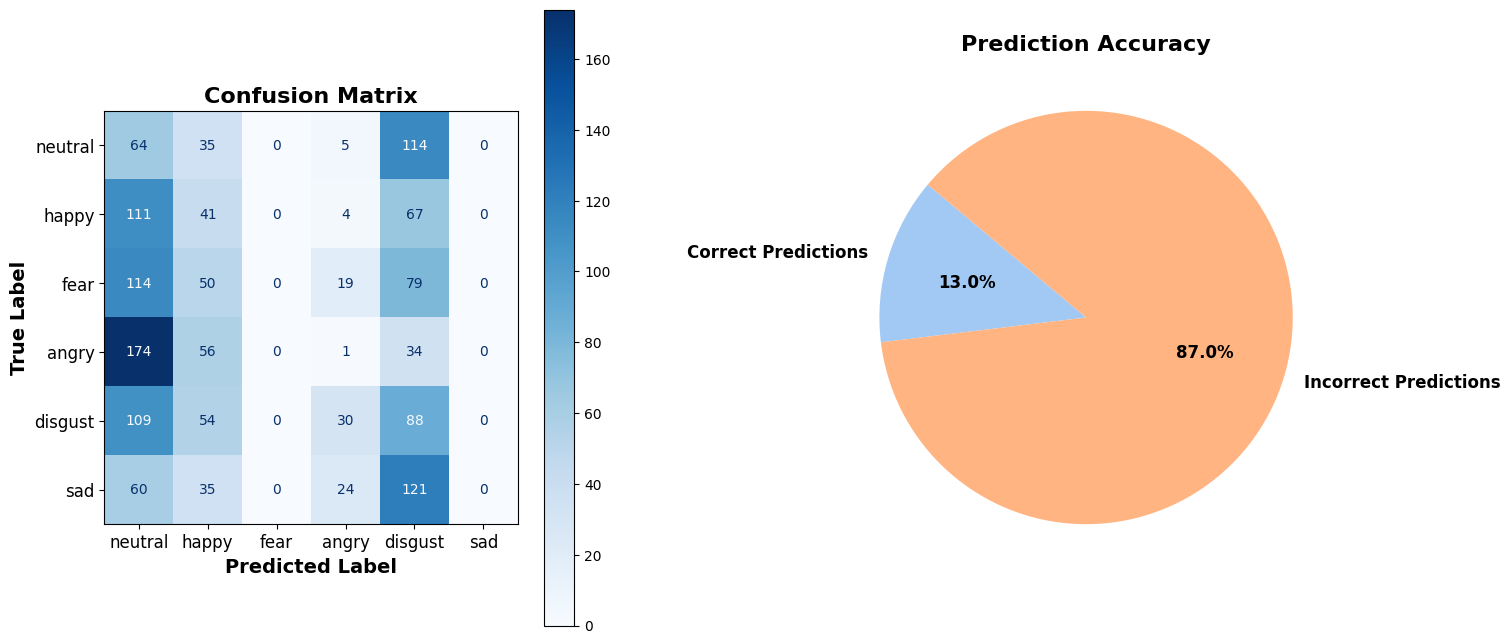

In [ ]:
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import Wav2Vec2ForSequenceClassification

# Load features from cache
def load_features(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    with open(file_path, "rb") as f:
        features = pickle.load(f)
    return features

# Define the EmotionDataset class to use precomputed features
class EmotionDataset(Dataset):
    def __init__(self, features):
        self.input_values = features['input_values']
        self.labels = features['labels']

    def __len__(self):
        return len(self.input_values)

    def __getitem__(self, idx):
        input_value = self.input_values[idx]
        label = self.labels[idx]
        return {'input_values': torch.tensor(input_value), 'labels': torch.tensor(label)}

# Split dataset into train and validation sets
def split_dataset(dataset, train_size=0.9):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_indices, val_indices = train_test_split(indices, train_size=train_size, shuffle=True)
    return Subset(dataset, train_indices), Subset(dataset, val_indices)

# Custom collate function to pad sequences
def collate_fn(batch):
    input_values = [item['input_values'] for item in batch]
    labels = torch.stack([item['labels'] for item in batch])
    input_values_padded = pad_sequence(input_values, batch_first=True)
    return {'input_values': input_values_padded, 'labels': labels}

# Load features
loaded_train_features = load_features("/content/drive/My Drive/features_cache/features_train.pkl")
loaded_test_features = load_features("/content/drive/My Drive/features_cache/features_test.pkl")

# Create datasets
train_dataset = EmotionDataset(loaded_train_features)
test_dataset = EmotionDataset(loaded_test_features)

# Perform the split for training data
train_dataset, val_dataset = split_dataset(train_dataset)

# Create DataLoaders with the custom collate function and optimizations
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)

# Load the pre-trained Wav2Vec2ForSequenceClassification model
num_emotions = 6  # Number of unique emotions
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=num_emotions)

# Move the model to the appropriate device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model on the test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_values)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


emotion_labels = ['neutral', 'happy', 'fear', 'angry', 'disgust', 'sad']
cm = confusion_matrix(true_labels, predictions, labels=range(num_emotions))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)

# Plot confusion matrix and pie chart

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
disp.plot(ax=axes[0], cmap=plt.cm.Blues, values_format='d')
axes[0].set_title("Confusion Matrix", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Predicted Label", fontsize=14, fontweight='bold')
axes[0].set_ylabel("True Label", fontsize=14, fontweight='bold')
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Calculate accuracy
correct_predictions = np.sum(np.array(true_labels) == np.array(predictions))
total_predictions = len(true_labels)
accuracy_percentage = (correct_predictions / total_predictions) * 100
incorrect_percentage = 100 - accuracy_percentage

# Prepare the data for the pie chart
pie_labels = ['Correct Predictions', 'Incorrect Predictions']
pie_sizes = [accuracy_percentage, incorrect_percentage]

# Pie Chart Plot
axes[1].pie(
    pie_sizes,
    labels=pie_labels,
    autopct=lambda p: f'{p:.1f}%',  # Display percentage with 1 decimal place
    startangle=140,
    colors=sns.color_palette('pastel'),
    textprops={'fontsize': 12, 'fontweight': 'bold'}  # Larger font size and bolder text
)
axes[1].set_title("Prediction Accuracy", fontsize=16, fontweight='bold')

plt.subplots_adjust(wspace=0.4)  # Increase space between plots

plt.show()

In [ ]:
!pip install -U optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


# Finetune

Using the following hyperparameters for the augmentations:

Optimal learning rate: 1.256e-5

Optimal weight decay: 0.04

Batch size : 16

Note: These parameters were selected based on Optuna tests conducted on the non-augmented dataset. The augmentation process increased the time required for hyperparameter tuning, so the parameters were chosen from earlier tests - see optuna fine tune later in the script

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import json
from transformers import Wav2Vec2ForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Set optimal hyperparameters
optimal_learning_rate = 1.2565e-5
optimal_weight_decay = 0.04
num_emotions = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define training arguments with optimal hyperparameters
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=optimal_learning_rate,
    per_device_train_batch_size=16,  # Update batch size as needed
    per_device_eval_batch_size=16,   # Update batch size as needed
    num_train_epochs=8,
    weight_decay=optimal_weight_decay,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    fp16=True,  # Enable mixed precision training
)

# Load the model with a classification head and move it to the device
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=num_emotions).to(device)

# Create Trainer instance with the optimal hyperparameters
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
)

# Train the model
trainer.train()

# Save the trained model
model_save_path = os.path.join("/content/drive/My Drive", "Final_Model_Aug")
os.makedirs(model_save_path, exist_ok=True)
model.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

# Evaluate the model
eval_result = trainer.evaluate()
print(f"Final evaluation result: {eval_result}")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should pr

Epoch,Training Loss,Validation Loss
1,1.086100,1.065450
2,0.807600,0.841313
3,0.612500,0.732009
4,0.633100,0.693358
5,0.498800,0.622736
6,0.395700,0.604621
7,0.315100,0.622795
8,0.270800,0.605953


<ipython-input-5-dd8313598cd5>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_values': torch.tensor(input_value), 'labels': torch.tensor(label)}
<ipython-input-5-dd8313598cd5>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_values': torch.tensor(input_value), 'labels': torch.tensor(label)}
<ipython-input-5-dd8313598cd5>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_values': torch.tensor(input_value), 'labels': torch.tensor(label)}
<ipython-input-5-dd8313598cd5>:31: UserWarning: To copy

Model saved to /content/drive/My Drive/Final_Model_Aug


<ipython-input-5-dd8313598cd5>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_values': torch.tensor(input_value), 'labels': torch.tensor(label)}


Final evaluation result: {'eval_loss': 0.6046209335327148, 'eval_runtime': 5.243, 'eval_samples_per_second': 340.646, 'eval_steps_per_second': 21.362, 'epoch': 8.0}


# Plot results

<ipython-input-5-dd8313598cd5>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_values': torch.tensor(input_value), 'labels': torch.tensor(label)}


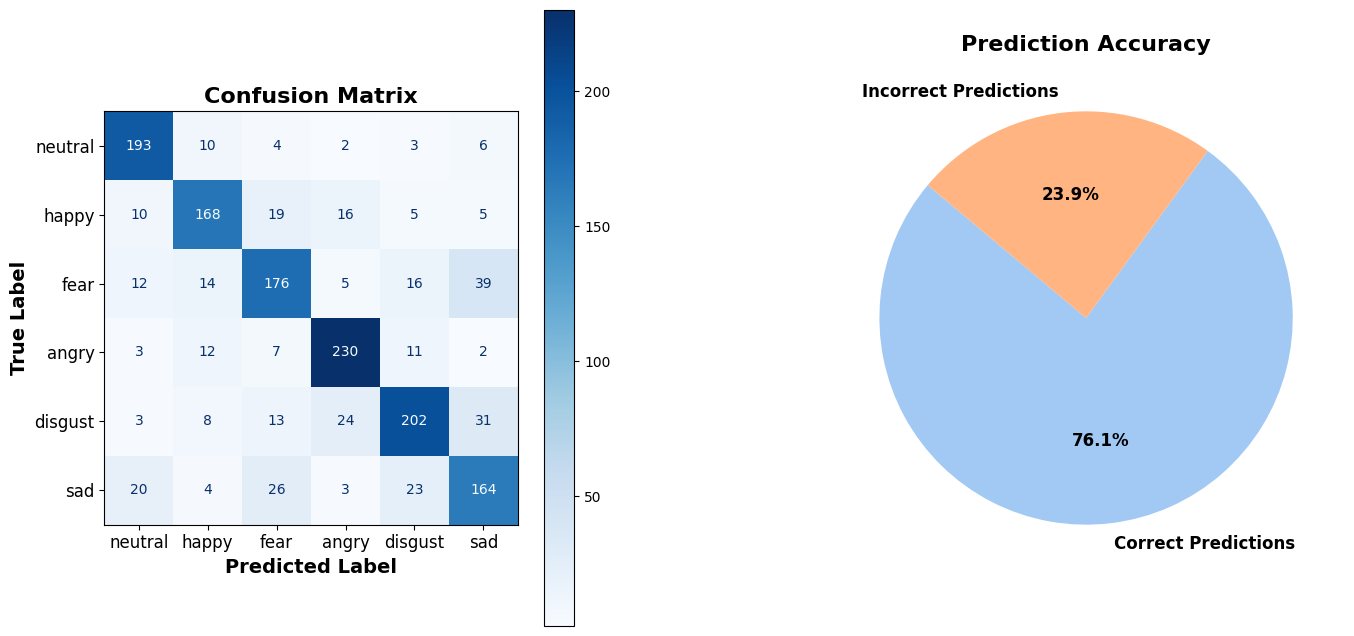

              precision    recall  f1-score   support

     Class 0       0.80      0.89      0.84       218
     Class 1       0.78      0.75      0.77       223
     Class 2       0.72      0.67      0.69       262
     Class 3       0.82      0.87      0.84       265
     Class 4       0.78      0.72      0.75       281
     Class 5       0.66      0.68      0.67       240

    accuracy                           0.76      1489
   macro avg       0.76      0.76      0.76      1489
weighted avg       0.76      0.76      0.76      1489



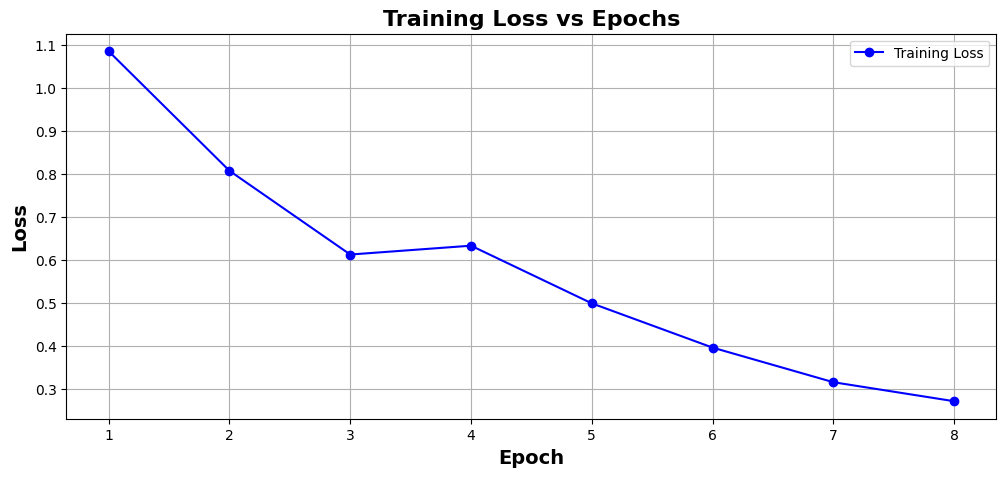

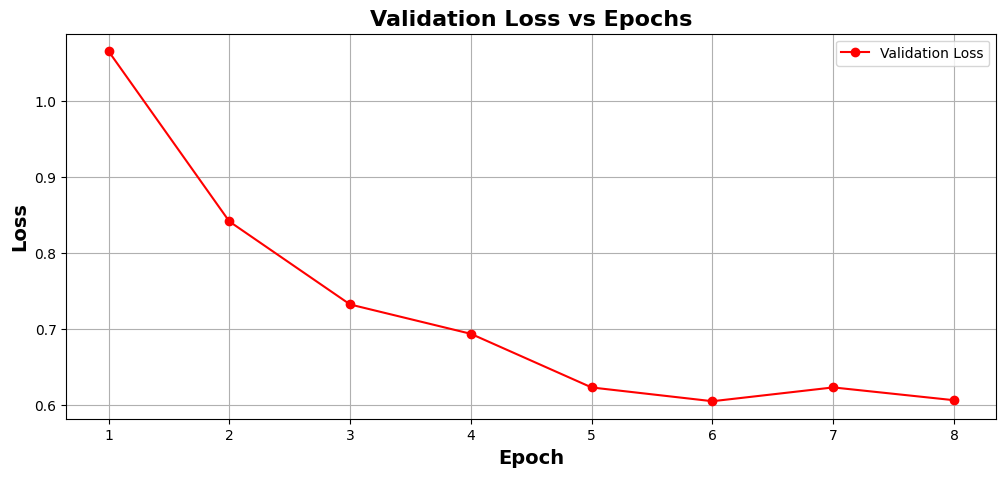

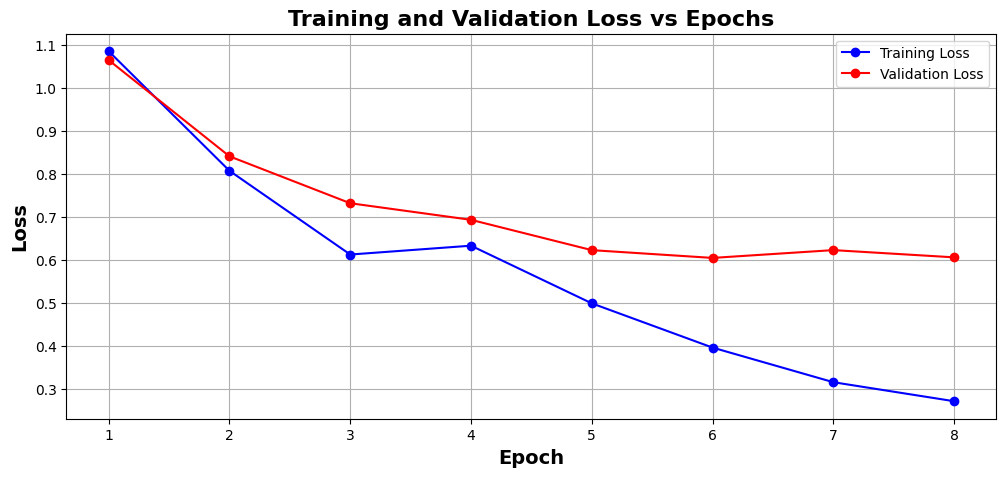

In [ ]:
# Make predictions on the test set
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=-1)
true_labels = predictions.label_ids

# Plotting the confusion matrix and pie chart
emotion_labels = ['neutral', 'happy', 'fear', 'angry', 'disgust', 'sad']
cm = confusion_matrix(true_labels, pred_labels, labels=range(num_emotions))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
disp.plot(ax=axes[0], cmap=plt.cm.Blues, values_format='d')
axes[0].set_title("Confusion Matrix", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Predicted Label", fontsize=14, fontweight='bold')
axes[0].set_ylabel("True Label", fontsize=14, fontweight='bold')
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Calculate accuracy
correct_predictions = np.sum(np.array(true_labels) == np.array(pred_labels))
total_predictions = len(true_labels)
accuracy_percentage = (correct_predictions / total_predictions) * 100
incorrect_percentage = 100 - accuracy_percentage

# Prepare the data for the pie chart
pie_labels = ['Correct Predictions', 'Incorrect Predictions']
pie_sizes = [accuracy_percentage, incorrect_percentage]
# Pie Chart Plot
axes[1].pie(
    pie_sizes,
    labels=pie_labels,
    autopct=lambda p: f'{p:.1f}%',  # Display percentage with 1 decimal place
    startangle=140,
    colors=sns.color_palette('pastel'),
    textprops={'fontsize': 12, 'fontweight': 'bold'}  # Larger font size and bolder text
)
axes[1].set_title("Prediction Accuracy", fontsize=16, fontweight='bold')

plt.subplots_adjust(wspace=0.4)  # Increase space between plots

plt.show()

# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=[f'Class {i}' for i in range(num_emotions)])
print(report)
epochs = [1, 2, 3, 4, 5, 6, 7, 8]
training_loss = [1.086100, 0.807600, 0.612500, 0.633100, 0.498800, 0.395700, 0.315100, 0.270800]
validation_loss = [1.065450, 0.841313, 0.732009, 0.693358, 0.622736, 0.604621, 0.622795, 0.605953]

# Plot training loss
plt.figure(figsize=(12, 5))
plt.plot(epochs, training_loss, label='Training Loss', color='blue', marker='o')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Training Loss vs Epochs', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation loss
plt.figure(figsize=(12, 5))
plt.plot(epochs, validation_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Validation Loss vs Epochs', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

# Plot both training and validation losses
plt.figure(figsize=(12, 5))
plt.plot(epochs, training_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Training and Validation Loss vs Epochs', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


# Optuna testing for finiding optimal hyperparamters - Best is trial number 4.

In [ ]:
from peft import get_peft_model, LoraConfig
import optuna
import os
import torch
import pickle
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from transformers import Wav2Vec2ForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

# Load features from cache
def load_features_from_cache(cache_dir="/content/drive/My Drive/features_cache"):
    features_file = os.path.join(cache_dir, "features.pkl")
    if not os.path.exists(features_file):
        raise FileNotFoundError(f"The file {features_file} does not exist.")
    with open(features_file, "rb") as f:
        features = pickle.load(f)
    return features

# Define the EmotionDataset class to use precomputed features
class EmotionDataset(Dataset):
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx]

# Split dataset into train, validation, and test sets
def split_dataset(dataset, train_size=0.8, val_size=0.1):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_indices, temp_indices = train_test_split(indices, train_size=train_size, shuffle=True)
    val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, shuffle=True)
    return Subset(dataset, train_indices), Subset(dataset, val_indices), Subset(dataset, test_indices)

# Custom collate function to pad sequences
def collate_fn(batch):
    input_values = [item['input_values'] for item in batch]
    labels = torch.stack([item['labels'] for item in batch])
    input_values_padded = pad_sequence(input_values, batch_first=True)
    return {'input_values': input_values_padded, 'labels': labels}

# Load the features and create the dataset
loaded_features = load_features_from_cache()
dataset = EmotionDataset(loaded_features)

# Perform the split
train_dataset, val_dataset, test_dataset = split_dataset(dataset)

# Create DataLoaders with the custom collate function
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Number of unique emotions
num_emotions = len(set(item['labels'].item() for item in loaded_features))  # or define manually if known

def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the wav2vec model with a classification head
    model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=num_emotions)
    model.to(device)

    # Suggest hyperparameters within a refined range
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 3e-5, log=True)
    batch_size = trial.suggest_int("batch_size", 6, 10, step=2)
    weight_decay = trial.suggest_float("weight_decay", 0.01, 0.04, log=True)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=8,
        weight_decay=weight_decay,
        logging_dir="./logs",
        logging_steps=10,
        load_best_model_at_end=True
    )

    # Create Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=collate_fn,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate()

    # Save the trained model
    model_save_path = os.path.join("/content/drive/My Drive/features_cache", "saved_model3")
    os.makedirs(model_save_path, exist_ok=True)
    model.save_pretrained(model_save_path)
    print(f"Model saved to {model_save_path}")

    return eval_result["eval_loss"]

# Define the Optuna study and optimize the objective function
def main():
    # Create an Optuna study
    study = optuna.create_study(direction="minimize")  # Minimize the evaluation loss
    study.optimize(objective, n_trials=10)  # Optimize over 10 trials (or any other number you prefer)

    # Print the best hyperparameters
    print("Best hyperparameters:")
    print(study.best_params)
    print("Best trial score:")
    print(study.best_value)

if __name__ == "__main__":
    main()


[I 2024-08-06 12:30:10,083] A new study created in memory with name: no-name-97526d91-7cd1-4f16-852a-e91758c245bf
/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/

Epoch,Training Loss,Validation Loss
1,1.039200,1.087566
2,0.819700,0.945801
3,0.660200,0.851959
4,0.538000,0.779267
5,0.412700,0.827524
6,0.281700,0.835576
7,0.417000,0.959720
8,0.299300,0.951383


[I 2024-08-06 12:54:26,923] Trial 0 finished with value: 0.7792674899101257 and parameters: {'learning_rate': 1.5340887047045442e-05, 'batch_size': 10, 'weight_decay': 0.013359221660411303}. Best is trial 0 with value: 0.7792674899101257.


Model saved to /content/drive/My Drive/features_cache/saved_model3


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated an

Epoch,Training Loss,Validation Loss
1,0.858500,1.020282
2,1.051500,1.021307
3,0.778300,0.932881
4,0.670800,0.890599
5,0.541300,1.089291
6,0.359200,1.147075
7,0.303400,1.286721
8,0.180200,1.269105


[I 2024-08-06 13:20:34,243] Trial 1 finished with value: 0.8905986547470093 and parameters: {'learning_rate': 1.5686425751904657e-05, 'batch_size': 6, 'weight_decay': 0.022562811899460095}. Best is trial 0 with value: 0.7792674899101257.


Model saved to /content/drive/My Drive/features_cache/saved_model3


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated an

Epoch,Training Loss,Validation Loss
1,1.059400,1.158711
2,0.841500,0.913388
3,0.696100,0.914651
4,0.596800,0.811826
5,0.384900,0.756346
6,0.305100,0.807120
7,0.284200,0.953161
8,0.306700,0.966578


[I 2024-08-06 13:44:43,373] Trial 2 finished with value: 0.7563455104827881 and parameters: {'learning_rate': 1.672561910012454e-05, 'batch_size': 10, 'weight_decay': 0.030562095152815695}. Best is trial 2 with value: 0.7563455104827881.


Model saved to /content/drive/My Drive/features_cache/saved_model3


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated an

Epoch,Training Loss,Validation Loss
1,0.967400,0.975100
2,0.810400,0.882309
3,0.689600,0.855936
4,0.482500,0.752311
5,0.435600,0.794306
6,0.234300,0.868698
7,0.267500,1.021406
8,0.268700,0.983778


[I 2024-08-06 14:08:45,807] Trial 3 finished with value: 0.7523109912872314 and parameters: {'learning_rate': 2.0736477613609685e-05, 'batch_size': 10, 'weight_decay': 0.020229495962928116}. Best is trial 3 with value: 0.7523109912872314.


Model saved to /content/drive/My Drive/features_cache/saved_model3


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated an

Epoch,Training Loss,Validation Loss
1,1.062900,1.104143
2,0.917600,0.997585
3,0.719100,0.835907
4,0.636000,0.761382
5,0.552300,0.740772
6,0.377500,0.729689
7,0.396400,0.891864
8,0.330700,0.823686


[I 2024-08-06 14:32:53,193] Trial 4 finished with value: 0.7296887636184692 and parameters: {'learning_rate': 1.256624853388738e-05, 'batch_size': 10, 'weight_decay': 0.03932106267367765}. Best is trial 4 with value: 0.7296887636184692.


Model saved to /content/drive/My Drive/features_cache/saved_model3


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated an

Epoch,Training Loss,Validation Loss
1,1.035400,1.194983
2,0.940900,1.051362
3,0.627800,0.856320
4,0.518600,0.865909
5,0.486600,0.829549
6,0.337300,0.943506
7,0.432300,0.927221
8,0.254100,0.974749


[I 2024-08-06 14:57:25,741] Trial 5 finished with value: 0.8295494914054871 and parameters: {'learning_rate': 1.3756418264472997e-05, 'batch_size': 8, 'weight_decay': 0.014087292299177986}. Best is trial 4 with value: 0.7296887636184692.


Model saved to /content/drive/My Drive/features_cache/saved_model3


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated an

Epoch,Training Loss,Validation Loss
1,1.007100,1.062571
2,1.033300,1.059808
3,0.629600,0.854882
4,0.415900,0.893692
5,0.422400,0.898064
6,0.302800,0.980114
7,0.345200,1.070189
8,0.195700,1.082020


[I 2024-08-06 15:21:53,806] Trial 6 finished with value: 0.8548823595046997 and parameters: {'learning_rate': 1.4504713248371821e-05, 'batch_size': 8, 'weight_decay': 0.01895744917713523}. Best is trial 4 with value: 0.7296887636184692.


Model saved to /content/drive/My Drive/features_cache/saved_model3


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated an

Epoch,Training Loss,Validation Loss
1,1.065500,1.179625
2,0.925200,0.938226
3,0.730500,0.901856
4,0.659000,0.813815
5,0.541300,0.784815
6,0.330600,0.803988
7,0.449700,0.925764
8,0.325600,0.888970


[I 2024-08-06 15:45:55,838] Trial 7 finished with value: 0.7848153710365295 and parameters: {'learning_rate': 1.242180680506521e-05, 'batch_size': 10, 'weight_decay': 0.01576068280008044}. Best is trial 4 with value: 0.7296887636184692.


Model saved to /content/drive/My Drive/features_cache/saved_model3


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated an

Epoch,Training Loss,Validation Loss
1,0.941500,1.105318
2,0.876200,0.991163
3,0.620400,0.883923
4,0.520100,0.784912
5,0.357700,0.850040
6,0.295200,0.968170
7,0.154800,1.220291
8,0.150000,1.158163


[I 2024-08-06 16:10:05,379] Trial 8 finished with value: 0.7849119305610657 and parameters: {'learning_rate': 2.7930698302066167e-05, 'batch_size': 10, 'weight_decay': 0.0384198776158266}. Best is trial 4 with value: 0.7296887636184692.


Model saved to /content/drive/My Drive/features_cache/saved_model3


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated an

Epoch,Training Loss,Validation Loss
1,1.017600,1.125833
2,0.878800,0.906288
3,0.684200,0.863508
4,0.528500,0.787818
5,0.529000,0.766971
6,0.302400,0.787082
7,0.323300,0.966273
8,0.297200,0.916910


[I 2024-08-06 16:34:13,308] Trial 9 finished with value: 0.7669708728790283 and parameters: {'learning_rate': 1.6147325706526216e-05, 'batch_size': 10, 'weight_decay': 0.030385148715819203}. Best is trial 4 with value: 0.7296887636184692.


Model saved to /content/drive/My Drive/features_cache/saved_model3
Best hyperparameters:
{'learning_rate': 1.256624853388738e-05, 'batch_size': 10, 'weight_decay': 0.03932106267367765}
Best trial score:
0.7296887636184692


# Test with our recorded audio

In [ ]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
import torch
import os
import torchaudio

# Initialize the feature extractor and model
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
model_save_path = os.path.join("/content/drive/My Drive", "Final_Model_Aug")
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_save_path)
model.eval()

def preprocess_audio(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)

    # Ensure the waveform is mono (single channel)
    if waveform.size(0) > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # Resample if needed
    if sample_rate != feature_extractor.sampling_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=feature_extractor.sampling_rate)
        waveform = resampler(waveform)

    # Extract features with padding and truncation
    inputs = feature_extractor(
        waveform.squeeze().numpy(),
        sampling_rate=feature_extractor.sampling_rate,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=40000  # Set a fixed max_length value
    )

    # Return input values with the correct shape
    return inputs.input_values.squeeze(0)  # Ensure it's [sequence_length] or [batch_size, sequence_length]

# Paths to your WAV files
wav_file_paths = [
    os.path.join("/content/drive/My Drive/Final_Model_Aug", "Hadar-angry.wav"),
    os.path.join("/content/drive/My Drive/Final_Model_Aug", "Hadar-happy (1).wav"),
    os.path.join("/content/drive/My Drive/Final_Model_Aug", "Hadar-happy (2).wav"),
    os.path.join("/content/drive/My Drive/Final_Model_Aug", "Hadar-NEU.wav")

]

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Debugging to check input shapes and predictions
for wav_file_path in wav_file_paths:
    input_values = preprocess_audio(wav_file_path)

    # Ensure input values are 2D tensor (batch_size, sequence_length)
    input_values = input_values.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        outputs = model(input_values)
        logits = outputs.logits

    predicted_id = torch.argmax(logits, dim=-1).item()
    label_names = ['neutral', 'happy', 'fear', 'angry', 'disgust', 'sad']
    predicted_label = label_names[predicted_id]

    print(f"Predicted emotion for '{os.path.basename(wav_file_path)}': {predicted_label}")



Predicted emotion for 'Hadar-angry.wav': angry
Predicted emotion for 'Hadar-happy (1).wav': happy
Predicted emotion for 'Hadar-happy (2).wav': happy
Predicted emotion for 'Hadar-NEU.wav': fear
